# BitNet

https://arxiv.org/pdf/2310.11453

What's the simplest network we could train using a regular Linear layer, so that we have a baseline to compare a BitLinear layer?

In [647]:
weights = torch.tensor([[
    -1, 0, 0, 1, -1
]])

In [648]:
torch.rand((1, 4))


tensor([[0.5407, 0.2908, 0.5983, 0.8868]])

In [649]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets
import torchvision.transforms.v2 as transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Dataset

Let's work with MNIST. It's quick, easy, and real-world enough that the results matter.

In [650]:
mnist = datasets.MNIST("~/.data", transform=transforms.Compose([transforms.PILToTensor(), transforms.ToDtype(torch.float32, scale=True)]))
mnist_dl = DataLoader(mnist, batch_size=600) # 100 batches

### Linear layer model

Let's use a simple Linear layer to get a baseline. Then, we'll replace the Linear layer with a BitLinear layer and compare.

In [651]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),  # TODO: Replace this with a BitLinear layer. Compare results.
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1),
)

In [652]:
def train(model, dl, lr=0.001):
    it = iter(dl)
    losses = []
    for xs, ys in tqdm(it, total=100):
        ps = model(xs)
        loss = -torch.gather(ps, 1, ys.unsqueeze(1)).mean()
        losses.append(loss.detach())
        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                p -= p.grad * lr
    return model, losses

In [653]:
model, losses = train(model, mnist_dl)

  0%|          | 0/100 [00:00<?, ?it/s]

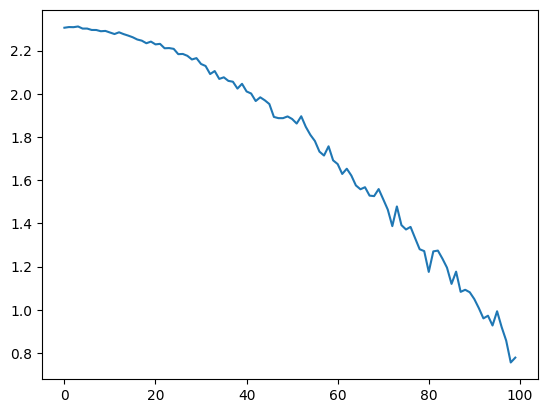

In [654]:
plt.plot(range(100), losses)

In [655]:
test = [mnist[i] for i in torch.randperm(len(mnist))[:100]]
xs, ys = zip(*test)
xs, ys = torch.stack(xs), torch.tensor(ys)
xs.shape, ys.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [656]:
ps = model(xs)
ps.argmax(dim=1) == ys

tensor([ True,  True,  True,  True,  True, False, False,  True,  True, False,
        False,  True,  True,  True,  True, False, False,  True, False,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
        False,  True,  True, False,  True,  True,  True,  True, False, False,
         True, False,  True, False, False,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True, False,
         True,  True, False,  True, False,  True,  True,  True,  True, False,
         True, False,  True,  True, False,  True,  True,  True,  True,  True])

In [657]:
accuracy = (ps.argmax(dim=1) == ys).sum() / len(ys)
accuracy.item()

0.7400000095367432

### BitLinear

Now let's try to implement the BitLinear layer. We'll just go line-by-line down the paper.

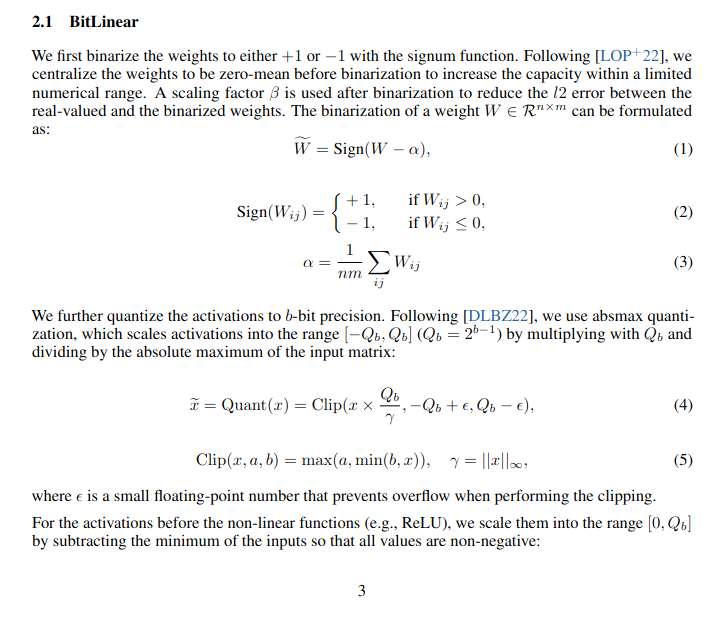

In [659]:
# 2.1.1 - 2.1.3
# Re-ordered from the paper so they'll execute.
torch.manual_seed(42)
W = torch.randn((4, 2))  # Random weights.

# (2)
def Sign(Wij):
    return torch.where(Wij > 0, 1, -1).to(torch.int8)

# (3)
α = W.mean()  # α is unicode 03b1

# (1)
Ẅ = Sign(W - α)  # Ẅ is unicode 1e84

In [660]:
W, Ẅ, Ẅ.dtype

(tensor([[ 0.3367,  0.1288],
         [ 0.2345,  0.2303],
         [-1.1229, -0.1863],
         [ 2.2082, -0.6380]]),
 tensor([[ 1, -1],
         [ 1,  1],
         [-1, -1],
         [ 1, -1]], dtype=torch.int8),
 torch.int8)

In [661]:
sample_weights = torch.tensor([
    [-1.5, 0.5,  2.5],
    [3.2,  1.2, -3.3]
])
sample_weights

tensor([[-1.5000,  0.5000,  2.5000],
        [ 3.2000,  1.2000, -3.3000]])

In [662]:
x = torch.arange(8).view(2, 4).to(torch.float32)
x

tensor([[0., 1., 2., 3.],
        [4., 5., 6., 7.]])

In [663]:
x, Ẅ

(tensor([[0., 1., 2., 3.],
         [4., 5., 6., 7.]]),
 tensor([[ 1, -1],
         [ 1,  1],
         [-1, -1],
         [ 1, -1]], dtype=torch.int8))

In [664]:
x.mean()

tensor(3.5000)

In [665]:
x, torch.where(x <= 0, -1, 1)

(tensor([[0., 1., 2., 3.],
         [4., 5., 6., 7.]]),
 tensor([[-1,  1,  1,  1],
         [ 1,  1,  1,  1]]))

In [666]:
torch.where(x - x.mean() <= 0, -1, 1)

tensor([[-1, -1, -1, -1],
        [ 1,  1,  1,  1]])

In [667]:
# 2.1.4 - 2.1.6
x = torch.tensor([[-1, 0.0], [1, 2]])  # Arbitrary input
ε = 1e-5                             # 03b5
b = 8                                # 8-bit quantization
Qb = 2**(b-1)

# (4)
def Quant_1(x):
    """
    From the paper:

        We further quantize the activations to b-bit precision. Following [DLBZ22 ], we use absmax quanti-
        zation, which scales activations into the range [−Qb, Qb] (Qb = 2b−1) by multiplying with Qb and
        dividing by the absolute maximum of the input matrix
    """
    return Clip(x * (Qb / γ(x)), -Qb + ε, Qb - ε).to(torch.int8)

# (5)
def γ(x):  # 03b3
    return x.abs().max()

# (5)
def Clip(xs, a, b):  # a=min, b=max
    return torch.clamp(xs, a, b)

# (6)
def Quant_2(x):
    """
    From the paper:
    
        For the activations before the non-linear functions (e.g., ReLU), we scale them into the range [0, Qb]
        by subtracting the minimum of the inputs so that all values are non-negative
    """
    return Clip((x - x.min()) * (Qb / γ(x)), -Qb + ε, Qb - ε).to(torch.int8)

In [668]:
# How does Quant_1 transform x?
x, Quant_1(x)

(tensor([[-1.,  0.],
         [ 1.,  2.]]),
 tensor([[-64,   0],
         [ 64, 127]], dtype=torch.int8))

In [669]:
# How does Quant_2 transform x?
x, Quant_2(x)

(tensor([[-1.,  0.],
         [ 1.,  2.]]),
 tensor([[  0,  64],
         [127, 127]], dtype=torch.int8))

In [670]:
ẍ = Quant_1(x)  # 1e8d

In [671]:
Ẅ, ẍ, x

(tensor([[ 1, -1],
         [ 1,  1],
         [-1, -1],
         [ 1, -1]], dtype=torch.int8),
 tensor([[-64,   0],
         [ 64, 127]], dtype=torch.int8),
 tensor([[-1.,  0.],
         [ 1.,  2.]]))

In [672]:
# "With the above quantization equations, the matrix multiplication can be written as:
# y = Ẅẍ  
# (But F.linear does xW.t. See Microsoft paper: https://github.com/microsoft/unilm/blob/master/bitnet/The-Era-of-1-bit-LLMs__Training_Tips_Code_FAQ.pdf)
y = F.linear(ẍ, Ẅ)
y

tensor([[-64, -64,  64, -64],
        [-63, -65,  65, -63]], dtype=torch.int8)

In [673]:
F.linear(ẍ, Ẅ)

tensor([[-64, -64,  64, -64],
        [-63, -65,  65, -63]], dtype=torch.int8)

In [674]:
W.dtype, x.dtype, Ẅ.dtype, ẍ.dtype

(torch.float32, torch.float32, torch.int8, torch.int8)

# BitLinear Module

## TODO: Complete

The next few cells will fail. I'm leaving them here as a placeholder while I figure out what to do.

In [677]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch import Tensor


class RMSNorm(nn.Module):
    def __init__(self, dim, eps: float = 1e-8, bias: bool = False) -> None:
        super(RMSNorm, self).__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.empty(dim))
        if bias:
            self.bias = nn.Parameter(torch.empty(dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.ones_(self.scale)
        if self.bias is not None:
            init.zeros_(self.bias)

    def forward(self, input: Tensor) -> Tensor:
        var = input.pow(2).mean(dim=-1, keepdim=True) + self.eps
        input_norm = input * torch.rsqrt(var)

        rmsnorm = self.scale * input_norm

        if self.bias is not None:
            rmsnorm = rmsnorm + self.bias

        return rmsnorm

In [678]:
class BitLinear(nn.Linear):
    def __init__(self, input_dims, output_dims, *args, **kwargs):
        super().__init__(input_dims, output_dims, *args, **kwargs)
        self.rms = RMSNorm((input_dims,))
        self.first_run = True  # Only used for demonstrating proof-of-concept

    def forward(self, x):
        w = self.weight
        x_norm = self.rms(x)
        # A trick for implementing Straight-Through-Estimator (STE) using detach()
        x_quant = x_norm + (Quant_1(x_norm) - x_norm).detach()
        w_quant = w + (Sign(w) - w).detach()
        # Just to prove that we're doing operations on 1-bit weights and 8-bit activations, let's log it the first time.
        if self.first_run == True:
            print(f"quantized inputs: x.min() {x_quant.min()}, x.max() {x_quant.max()}")
            print(f"quantized weights: w.min() {w_quant.min()} w.max() {w_quant.max()}")
            self.first_run = False
        y = F.linear(x_quant, w_quant)
        return y

In [679]:
model = nn.Sequential(
    nn.Flatten(),
    BitLinear(784, 128, bias=False),  # TODO: Replace this with a BitLinear layer. Compare results.
    BitLinear(128, 10, bias=False),
    nn.LogSoftmax(dim=1),
)

In [680]:
def train(model, dl, lr=0.001):
    it = iter(dl)
    losses = []
    for xs, ys in tqdm(it, total=100):
        ps = model(xs)
        loss = -torch.gather(ps, 1, ys.unsqueeze(1)).mean()
        losses.append(loss.detach())
        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                p -= p.grad * lr
    return model, losses

In [681]:
model, losses = train(model, mnist_dl)

  0%|          | 0/100 [00:00<?, ?it/s]

quantized inputs: x.min() 0.0, x.max() 127.0
quantized weights: w.min() -1.0 w.max() 1.0
quantized inputs: x.min() -123.0, x.max() 127.0
quantized weights: w.min() -1.0 w.max() 1.0


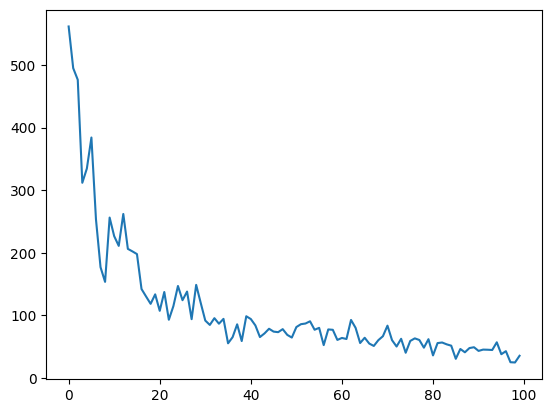

In [682]:
plt.plot(range(100), losses)

In [683]:
test = [mnist[i] for i in torch.randperm(len(mnist))[:100]]
xs, ys = zip(*test)
xs, ys = torch.stack(xs), torch.tensor(ys)
xs.shape, ys.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [684]:
ps = model(xs)
ps.argmax(dim=1) == ys

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True, False,  True, False,  True,
        False,  True,  True,  True,  True,  True, False,  True, False,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True, False,  True,  True, False,  True,  True, False])

In [685]:
accuracy = (ps.argmax(dim=1) == ys).sum() / len(ys)
accuracy.item()

0.8399999737739563

# Normalization

Demonstrate Karpathy's explanation: https://youtu.be/P6sfmUTpUmc?t=2540

First, what _is_ "unit gaussian"?

https://stats.stackexchange.com/questions/248776/can-someone-explain-intuitively-what-does-0-mean-and-unit-variance-mean

https://en.wikipedia.org/wiki/Normal_distribution

> Standard normal distribution
>
> The simplest case of a normal distribution is known as the standard normal distribution or unit normal distribution. This is a special case when μ = 0 {\textstyle \mu =0} and σ 2 = 1 {\textstyle \sigma ^{2}=1}, and it is described by this probability density function (or density): 

In [462]:
# We can generate that with torch.normal
example = torch.normal(0, 1, (1, 4))
example.mean(), example.std(), example

(tensor(-0.0534),
 tensor(0.3979),
 tensor([[-0.2261,  0.4935, -0.4355, -0.0453]]))

In [471]:
# Imagine we have a hidden layer with outputs that are _not_ unit Gaussian.
hidden_layer = torch.tensor([[
    -1.0, 2.5, 5.2, -1.5, 3.3
]])
hidden_layer.mean(), hidden_layer.std(), hidden_layer

(tensor(1.7000),
 tensor(2.8714),
 tensor([[-1.0000,  2.5000,  5.2000, -1.5000,  3.3000]]))

In [472]:
hidden_mean, hidden_std = hidden_layer.mean(), hidden_layer.std()

In [473]:
hidden_scaled = (hidden_layer - hidden_mean)
hidden_scaled

tensor([[-2.7000,  0.8000,  3.5000, -3.2000,  1.6000]])

In [474]:
hidden_scaled = hidden_scaled / hidden_std
hidden_scaled, hidden_scaled.mean(), hidden_scaled.std()

(tensor([[-0.9403,  0.2786,  1.2189, -1.1144,  0.5572]]),
 tensor(0.),
 tensor(1.))

In [475]:
hidden_unscaled = (hidden_scaled * hidden_std) + hidden_mean
hidden_unscaled

tensor([[-1.0000,  2.5000,  5.2000, -1.5000,  3.3000]])

## Distribution of -1, 0, 1 of rounded/clipped standard normal distribution?

How many -1, 0, and 1 would you get if you took a tensor of 100 standard normal distribution numbers, rounded them, and clamped them to -1, 1?

In [493]:
example = torch.normal(0, 1, (1, 100000))
torch.clamp(example.round(), -1, 1).unique(return_counts=True)

(tensor([-1., -0.,  1.]), tensor([30895, 38234, 30871]))

Slightly more 0s than -1 and 1. Interesting.